In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, rossby_number, calc_tang_vel, find_directional_radii

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


5 year Dataset i.e. starting from the second year.


Eddy   Day Cyc         Lon        Lat   ic   jc          xc  \
6190    139  1828  CE  157.059283 -31.185958  202  217  604.463444   
6191    139  1829  CE  157.078842 -31.142351  202  218  604.826448   
6192    139  1830  CE  157.124214 -31.078168  202  219  606.871022   
6193    139  1831  CE  157.185960 -31.002953  203  221  610.051900   
6194    139  1832  CE  157.244347 -30.967634  204  223  614.225702   
...     ...   ...  ..         ...        ...  ...  ...         ...   
30571   661  3646  CE  152.918833 -38.395610  171   37  476.237996   
30572   661  3647  CE  152.971481 -38.375238  172   38  479.971110   
30573   661  3648  CE  153.053559 -38.364292  174   39  486.464553   
30574   661  3649  CE  153.169057 -38.316516  176   40  494.571680   
30575   661  3650  CE  153.083466 -38.327543  174   40  487.780311   

                yc       Q11       Q12       Q22         w  Age  \
6190   1070.031206 -0.015698  0.005227 -0.005541 -0.000042   25   
6191   1075.256459 -0.014436  0.004031 -0.005326 -0.000040   25   
6192   1083.491221 -0.010992  0.002657 -0.004730 -0.000031   25   
6193   1093.424471 -0.008855  0.001169 -0.004493 -0.000027   25   
6194   1099.054308 -0.008279  0.000785 -0.004631 -0.000026   25   
...            ...       ...       ...       ...       ...  ...   
30571   183.017279 -0.003693  0.002256 -0.006219 -0.000020   25   
30572   186.729214 -0.004736  0.002579 -0.005423 -0.000020   25   
30573   190.334431 -0.005506  0.003351 -0.005385 -0.000022   25   
30574   198.807592 -0.006269  0.003703 -0.005896 -0.000024   25   
30575   195.085839 -0.005774  0.004509 -0.006799 -0.000025   25   

                                                   fname  
6190   /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
6191   /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
6192   /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
6193   /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
6194   /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
...                                                  ...  
30571  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
30572  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
30573  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
30574  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  
30575  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  

[24120 rows x 15 columns]

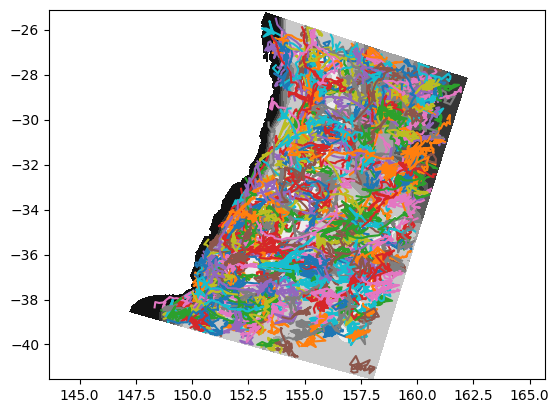

In [3]:
valid_eddies = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy == eddy]
    if np.all((df.Day >= 1827) & (df.Day <= 3652)):
        valid_eddies.append(eddy)
df_eddies_5yr = df_eddies[df_eddies.Eddy.isin(valid_eddies)]
plt.contourf(lon_rho, lat_rho, np.where(mask_rho, h, np.nan)/1000, cmap='grey')
for eddy in df_eddies_5yr.Eddy.unique():
    df = df_eddies_5yr[df_eddies_5yr.Eddy==eddy]
    plt.plot(df.Lon, df.Lat)
plt.axis('equal')
df_eddies_5yr


Calculate there vertical centers

In [4]:
def compute_vert_data(df_eddies, eddy, X, Y, z_r, r=30):

    df = df_eddies[df_eddies.Eddy == eddy].copy()
    dic_data = {f'Eddy{eddy}': {}}
    fnumber_old = None
    x, y = X[:,0], Y[0,:]
    timer = 0

    # DOPIOE wont work if too close to boundary
    dx = np.max(np.diff(x))  # spacing in x-direction
    dy = np.max(np.diff(y))  # spacing in y-direction
    cell_size = np.max([dx, dy])        # max cell size in Euclidean units
    margin = int(np.ceil(r / cell_size))    

    for t, data in df.iterrows():
        day, fname, xc_surf, yc_surf, w_surf = data['Day'], data['fname'], data['xc'], data['yc'], data['w']
        fnumber = fname[-8:-3]

        # Only load if file changes
        if fnumber != fnumber_old:
            u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
            v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
            u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
            v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
            with nc.Dataset(fname) as dataset:
                ocean_time = dataset.variables['ocean_time'][:].data / 86400
            fnumber_old = fnumber
        t_rel = np.where(ocean_time == day)[0][0]

        u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

        df_data = []
        xc, yc = xc_surf, yc_surf
        xc_old, yc_old = xc_surf, yc_surf

        # for k in range(24):
        for k in range(u_t.shape[-1]):
            u, v = u_t[:, :, k], v_t[:, :, k]

            R_grid = np.hypot(xc - X, yc - Y)
            ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))
            
            if (ic < margin or ic >= X.shape[0] - margin or
                jc < margin or jc >= X.shape[1] - margin):
                break

            # horizontal transect (constant y = y[jc])
            x_mask = np.abs(x - xc) <= r
            x1 = x[x_mask]
            y1 = np.full_like(x1, y[jc])
            u1 = u[x_mask, jc]
            v1 = v[x_mask, jc]
        
            # vertical transect (constant x = x[ic])
            y_mask = np.abs(y - yc) <= r
            y2 = y[y_mask]
            x2 = np.full_like(y2, x[ic])
            u2 = u[ic, y_mask]
            v2 = v[ic, y_mask]

            xc, yc, w, Q, _, psi0, _ = dopioe(x1, y1, u1, v1, x2, y2, u2, v2)

            if (np.sign(w) != np.sign(w_surf)) or (np.hypot(xc_old - xc, yc_old - yc) > 50):
                break
            
            xc_old, yc_old = xc, yc

            w *= 1e-3 # to s^-1
            # Ro = rossby_number(w, yc)

            radii = find_directional_radii(u, v, X, Y, xc, yc, calc_tang_vel)
            Rc = np.mean([radii['up'], radii['right'], radii['down'], radii['left']])

            df_data.append({
                'x': xc, 'y': yc, 'Q': Q, 'w': w,
                'Rc': Rc, 'psi0': psi0,
                'z': k, 'Depth': z_r[k]
            })

        if df_data:
            df_data = pd.DataFrame(df_data)
            dx = df_data['x'].diff()
            dy = df_data['y'].diff()
            df_data['TD'] = np.hypot(df_data['x'] - df_data.iloc[0]['x'],
                                  df_data['y'] - df_data.iloc[0]['y'])
            dic_data[f'Eddy{eddy}'][f'Day{day}'] = df_data
        else:
            dic_data[f'Eddy{eddy}'][f'Day{day}'] = pd.DataFrame(columns=['x', 'y', 'Q', 'w', 'Rc', 'psi0', 'z','Depth'])

        # if timer % 10 == 0:
        #     print(f'{timer / len(df) * 100:.1f}%')
        #     timer += 1
        
    return dic_data
    

In [5]:
# dic_5yr = {}
# for e, eddy in enumerate(df_eddies_5yr.ID.unique()):
#     dic = compute_vert_data(df_eddies, eddy, X_grid, Y_grid, z_r)
#     dic_5yr = dic_5yr | dic 
#     print(f'{e}/{len(df_eddies_5yr.ID.unique())}')

# with open('/srv/scratch/z5297792/Clim_data/year_tests/dic_5year_1827_3652_vert_info.pkl', 'wb') as f:
#     pickle.dump(dic_5yr, f)

#######################################################################################################
# with open('/srv/scratch/z5297792/Clim_data/year_tests/dic_1year_1827_2192_vert_info.pkl', 'rb') as f:
#     dic_1yr = pickle.load(f)

with open('/srv/scratch/z5297792/Clim_data/year_tests/dic_5year_1827_3652_vert_info.pkl', 'rb') as f:
    dic_5yr = pickle.load(f)
    

In [6]:
def bearing(a, b):
    dx = b[0] - a[0]
    dy = b[1] - a[1]
    angle_rad = np.arctan2(dx, dy)  # note the order: dx, dy
    angle_deg = np.degrees(angle_rad)
    bearing = (angle_deg + 360) % 360
    return bearing

def compute_tilt_data(dic, eddy, num=6, depth_int=10, max_depth=1000):
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()

        if len(df):
        
            depths       = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values)
            y_i = np.interp(valid, depths, df['y'].values)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # delta = np.hypot(dx, dy)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
        
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

        else:
            idx = [10]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    for ref_day in range(num //2, len(dic) - num //2):
    
        df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
        
        # Calculation of variability at each depth
        df_data = pd.DataFrame()
        df_data[r'$\Delta x$'] = df_X.mean(axis=1)
        df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
        df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
        df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
        df_data[r'$\sigma^2_{\Delta x}$'] = df_X.std(axis=1)
        df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.std(axis=1)
        df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
        df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
        df_data['Depth'] = df_data.index 
        df_data
        
        # Line of Best Fit
        
        # your data arrays of shape (N,)
        x = df_data[r'$\sum{\Delta x}$'].values
        y = df_data[r'$\sum{\Delta y}$'].values
        z = df_data['Depth'].values
        w = df_data['weight'].values
        
        # 1. compute weighted mean
        W = np.sum(w)
        mean = np.array([np.dot(w, x),
                         np.dot(w, y),
                         np.dot(w, z)]) / W
        
        # 2. center and weight the data
        X = np.vstack((x, y, z)).T
        Xc = X - mean
        Xw = Xc * np.sqrt(w)[:, None]
        
        # 3. SVD on weighted, centered data
        try:
            flag = 0
            _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
        except Exception:
            flag = 1
            # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
            
        if flag:
            
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic.keys())[ref_day][3:], 'TiltDis': np.nan, 'TiltDir': np.nan}
            
        else:
            
            direction = Vt[0]   # principal axis
            
            # The best-fit line is:  p(t) = mean + t * direction
            t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
            p = mean[None, :] + t[:, None] * direction  # shape (100,3)
            # or equivalently
            p = mean + np.outer(t, direction)          # also (100,3)
            
            # then split back out if you need x,y,z separately:
            x_line, y_line, z_line = p.T
            
            tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
            
            top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
            if top_idx == 1:
                btm_idx = 0
            else:
                btm_idx = 1
            top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
            btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
            tilt_direc = ( bearing(btm, top) + 20 ) % 360
        
            df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': list(dic.keys())[ref_day][3:], 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}
        
    df_tilt_data['Day'] = df_tilt_data['Day'].astype(int)
        
    return df_tilt_data


In [7]:
for e, eddy in enumerate(dic_5yr.keys()):
    dic = dic_5yr[eddy]
    df = compute_tilt_data(dic, int(eddy[4:]))
    if e == 0:
        df_tilt_data = df
    else:
        df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
df_tilt_data


Eddy   Day   TiltDis     TiltDir
0       139  1831  5.450166  281.862892
1       139  1832  3.148655  265.515548
2       139  1833  2.420232  211.183734
3       139  1834  3.824071  181.167664
4       139  1835  5.460166  175.806031
...     ...   ...       ...         ...
20995   661  3643  1.193491  140.959569
20996   661  3644  1.959289  202.305224
20997   661  3645  2.123659  232.532911
20998   661  3646  4.167315  239.219567
20999   661  3647  5.013918  235.898926

[21000 rows x 4 columns]

In [8]:
df_eddies_5yr = df_eddies_5yr.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies_5yr


Eddy   Day Cyc         Lon        Lat   ic   jc          xc  \
0       139  1828  CE  157.059283 -31.185958  202  217  604.463444   
1       139  1829  CE  157.078842 -31.142351  202  218  604.826448   
2       139  1830  CE  157.124214 -31.078168  202  219  606.871022   
3       139  1831  CE  157.185960 -31.002953  203  221  610.051900   
4       139  1832  CE  157.244347 -30.967634  204  223  614.225702   
...     ...   ...  ..         ...        ...  ...  ...         ...   
24115   661  3646  CE  152.918833 -38.395610  171   37  476.237996   
24116   661  3647  CE  152.971481 -38.375238  172   38  479.971110   
24117   661  3648  CE  153.053559 -38.364292  174   39  486.464553   
24118   661  3649  CE  153.169057 -38.316516  176   40  494.571680   
24119   661  3650  CE  153.083466 -38.327543  174   40  487.780311   

                yc       Q11       Q12       Q22         w  Age  \
0      1070.031206 -0.015698  0.005227 -0.005541 -0.000042   25   
1      1075.256459 -0.014436  0.004031 -0.005326 -0.000040   25   
2      1083.491221 -0.010992  0.002657 -0.004730 -0.000031   25   
3      1093.424471 -0.008855  0.001169 -0.004493 -0.000027   25   
4      1099.054308 -0.008279  0.000785 -0.004631 -0.000026   25   
...            ...       ...       ...       ...       ...  ...   
24115   183.017279 -0.003693  0.002256 -0.006219 -0.000020   25   
24116   186.729214 -0.004736  0.002579 -0.005423 -0.000020   25   
24117   190.334431 -0.005506  0.003351 -0.005385 -0.000022   25   
24118   198.807592 -0.006269  0.003703 -0.005896 -0.000024   25   
24119   195.085839 -0.005774  0.004509 -0.006799 -0.000025   25   

                                                   fname   TiltDis     TiltDir  
0      /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN         NaN  
1      /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN         NaN  
2      /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN         NaN  
3      /srv/scratch/z3533156/26year_BRAN2020/outer_av...  5.450166  281.862892  
4      /srv/scratch/z3533156/26year_BRAN2020/outer_av...  3.148655  265.515548  
...                                                  ...       ...         ...  
24115  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  4.167315  239.219567  
24116  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  5.013918  235.898926  
24117  /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN         NaN  
24118  /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN         NaN  
24119  /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN         NaN  

[24120 rows x 17 columns]

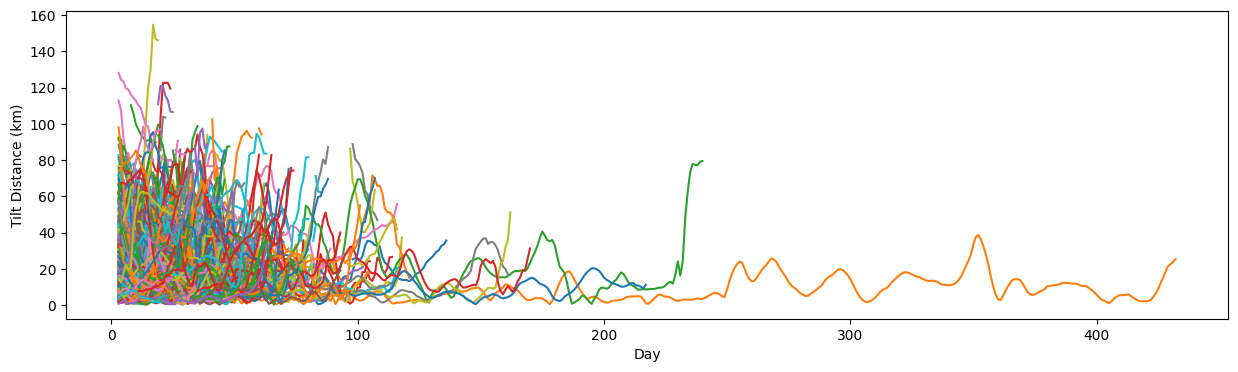

In [9]:
plt.figure(figsize=(15,4))
for eddy in df_eddies_5yr.Eddy.unique():
    df = df_eddies_5yr[df_eddies_5yr.Eddy==eddy]
    plt.plot(np.arange(len(df)), df['TiltDis'])
    plt.xlabel('Day')
    plt.ylabel('Tilt Distance (km)')
    

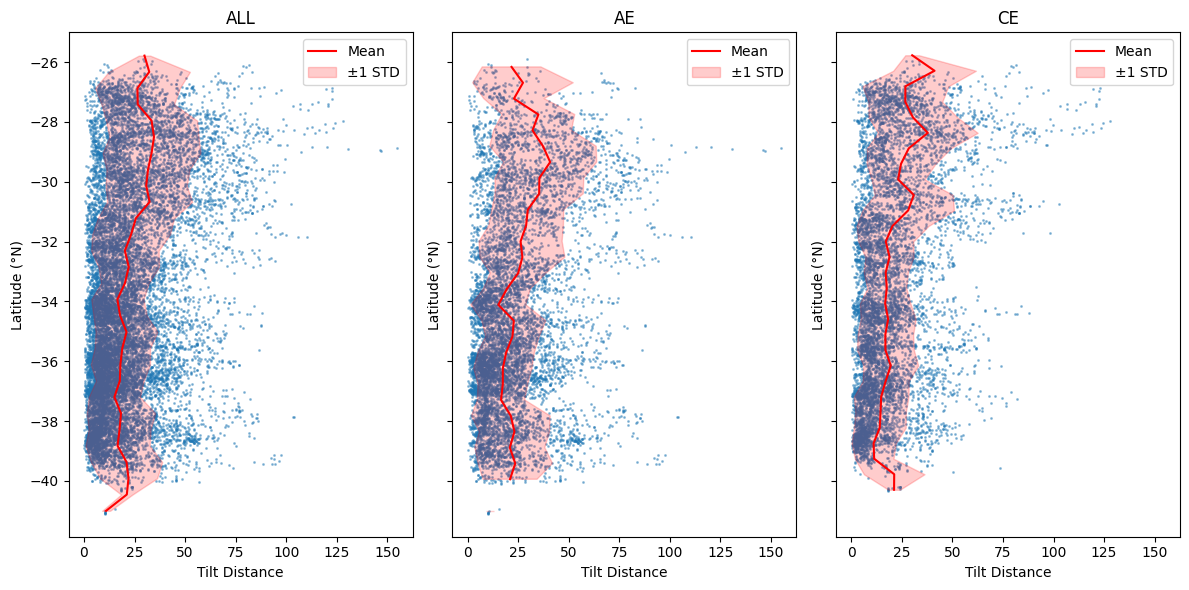

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True, sharex=True)

for p, cyc in enumerate(['ALL', 'AE', 'CE']):

    if cyc == 'ALL':
        df_masked = df_eddies_5yr.copy()
    else:
        df_masked = df_eddies_5yr[df_eddies_5yr.Cyc==cyc].copy()
    x = df_masked['TiltDis']
    y = df_masked['Lat']
    
    # Bin by y (latitude)
    bins = np.linspace(y.min(), y.max(), 30)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    digitized = np.digitize(y, bins)
    
    # Compute mean and std of x in each y-bin
    mean = [x[digitized == i].mean() for i in range(1, len(bins))]
    std = [x[digitized == i].std() for i in range(1, len(bins))]
    
    # Plot
    axs[p].scatter(x, y, marker='.', s=5, alpha=0.4)
    axs[p].plot(mean, bin_centers, color='red', label='Mean')
    axs[p].fill_betweenx(bin_centers,
                      np.array(mean) - np.array(std),
                      np.array(mean) + np.array(std),
                      color='red', alpha=0.2, label='±1 STD')
    axs[p].set_xlabel('Tilt Distance')
    axs[p].set_ylabel('Latitude (°N)')
    axs[p].set_title(cyc)
    axs[p].legend()
plt.tight_layout()


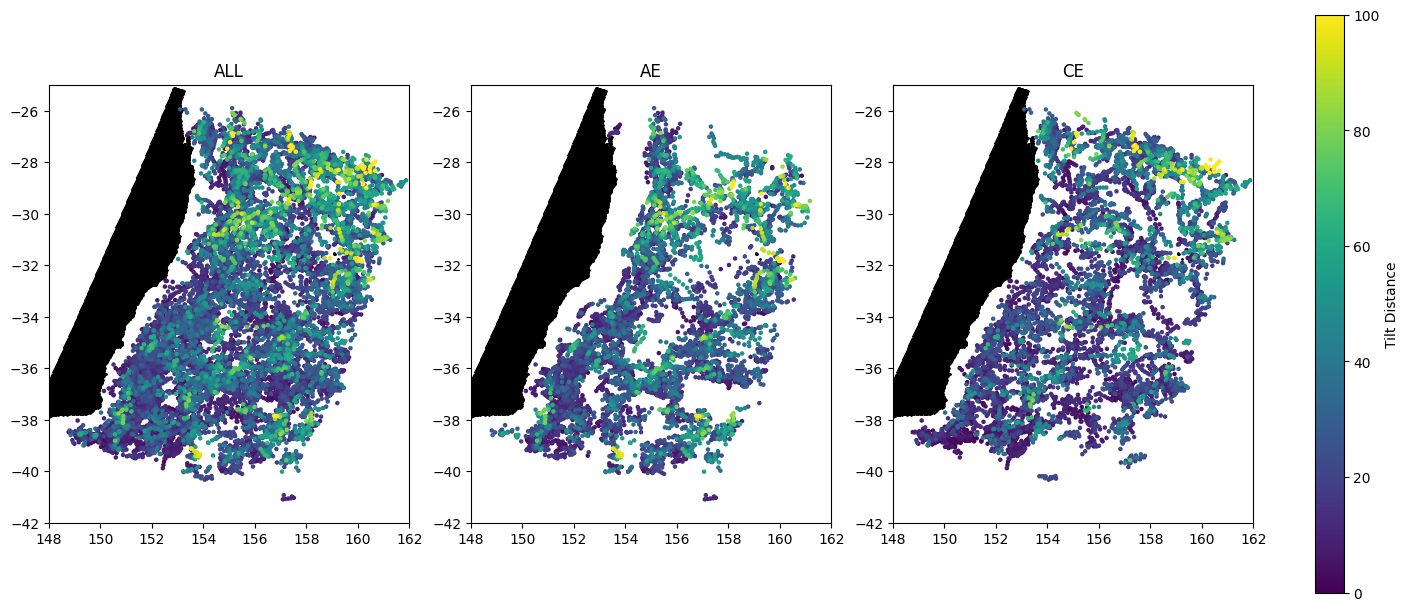

In [11]:
mask = mask_rho == 0
vmin, vmax = 0, 100

fig, axs = plt.subplots(1, 3, figsize=(14, 6), constrained_layout=True)

for p, cyc in enumerate(['ALL', 'AE', 'CE']):
    if cyc == 'ALL':
        df = df_eddies_5yr.copy()
    else:
        df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()

    df = df.sort_values(by='TiltDis').reset_index(drop=True)
    axs[p].scatter(lon_rho[mask], lat_rho[mask], color='k', s=1)
    sc = axs[p].scatter(df.Lon, df.Lat, c=df.TiltDis, s=5, vmin=vmin, vmax=vmax)
    axs[p].set_ylim(-42, -25)
    axs[p].set_xlim(148, 162)
    axs[p].set_aspect('equal')
    axs[p].set_title(cyc)

cbar = fig.colorbar(sc, ax=axs, orientation='vertical', fraction=0.025, pad=0.04)
cbar.set_label('Tilt Distance')

plt.show()


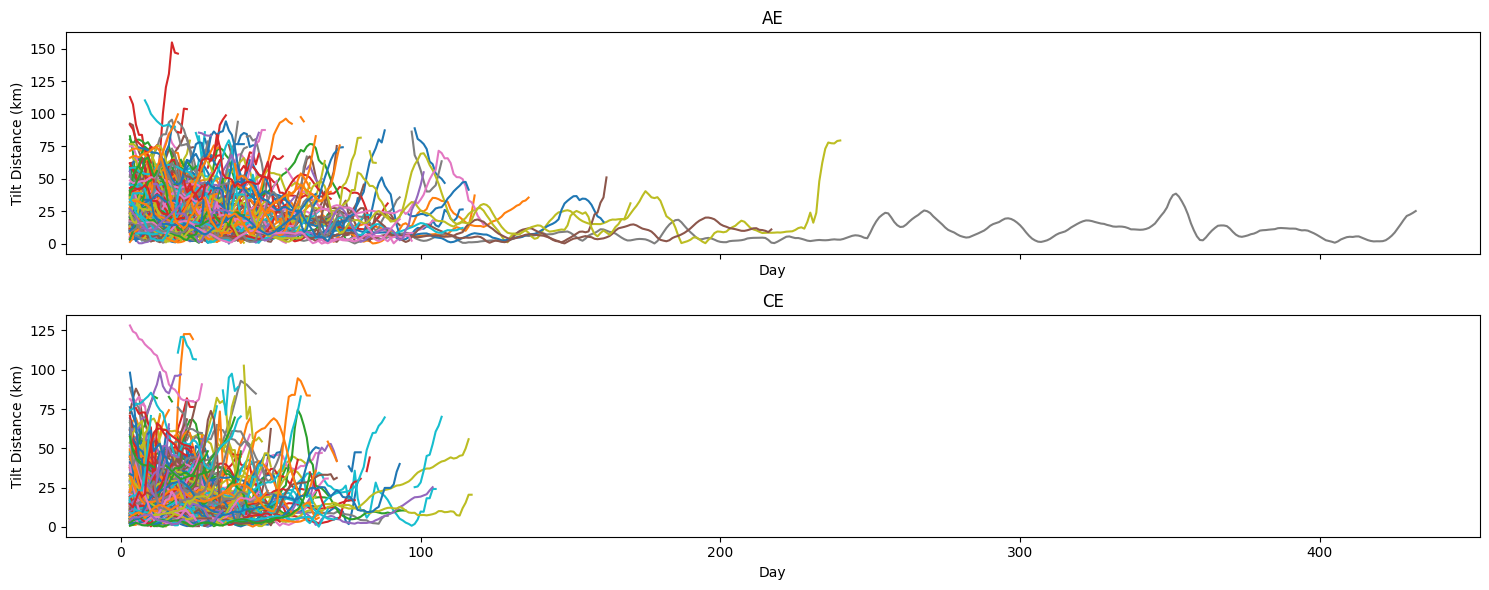

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
for eddy in df_eddies_5yr.Eddy.unique():
    df = df_eddies_5yr[df_eddies_5yr.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis)
        axs[0].set_xlabel('Day')
        axs[0].set_ylabel('Tilt Distance (km)')
        axs[0].set_title('AE')
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis)
        axs[1].set_xlabel('Day')
        axs[1].set_ylabel('Tilt Distance (km)')
        axs[1].set_title('CE')
plt.tight_layout()


In [13]:
AE_TD_mean = df_eddies_5yr[df_eddies_5yr.Cyc=='AE'].TiltDis.mean()
CE_TD_mean = df_eddies_5yr[df_eddies_5yr.Cyc=='CE'].TiltDis.mean()
print(f'AE Tilt Distance Mean: {round(AE_TD_mean)}km')
print(f'CE Tilt Distance Mean: {round(CE_TD_mean)}km')


AE Tilt Distance Mean: 24km
CE Tilt Distance Mean: 20km


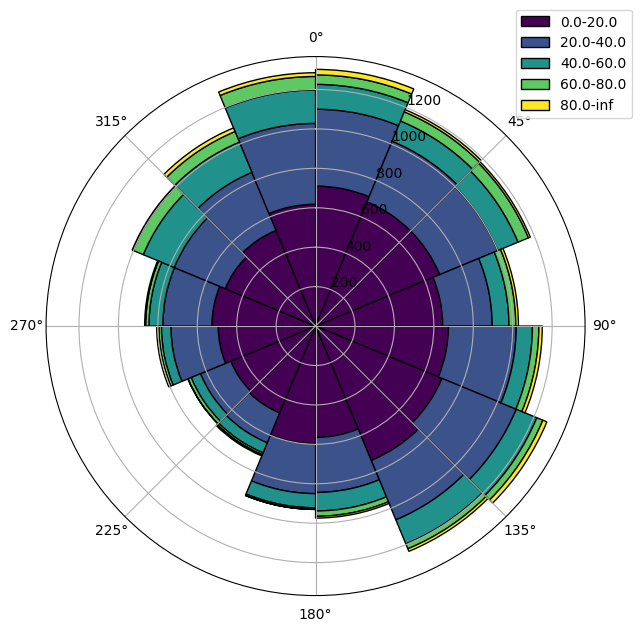

In [14]:
# Replace these with your actual data arrays
directions = df_eddies_5yr.TiltDir
magnitudes = df_eddies_5yr.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


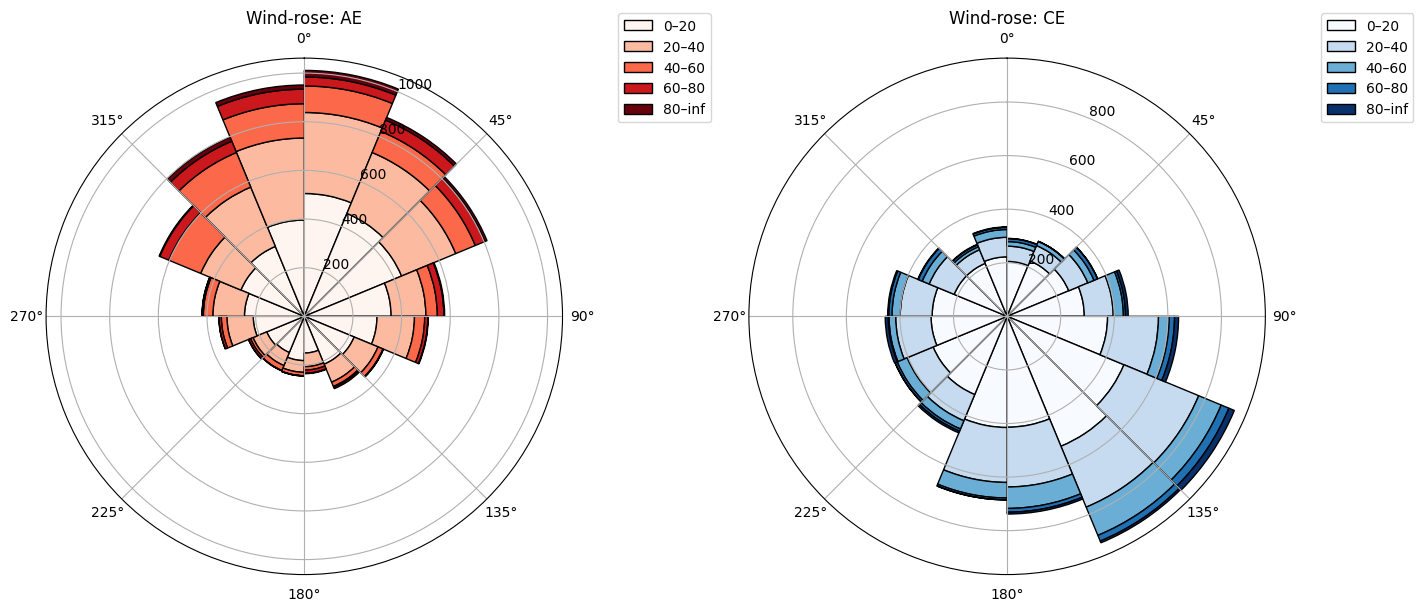

In [15]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

df_AE = df_eddies_5yr[df_eddies_5yr.Cyc=='AE'].copy()
df_CE = df_eddies_5yr[df_eddies_5yr.Cyc=='CE'].copy()

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f'Wind‑rose: {title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# One legend for both
plt.show()


In [16]:
eddy_props = []
for eddy in df_eddies_5yr.Eddy.unique():
    df = df_eddies_5yr[df_eddies_5yr.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) / 1 * 0.011574))
df_eddies_5yr['EddyProp'] = eddy_props
df_eddies_5yr


Eddy   Day Cyc         Lon        Lat   ic   jc          xc  \
0       139  1828  CE  157.059283 -31.185958  202  217  604.463444   
1       139  1829  CE  157.078842 -31.142351  202  218  604.826448   
2       139  1830  CE  157.124214 -31.078168  202  219  606.871022   
3       139  1831  CE  157.185960 -31.002953  203  221  610.051900   
4       139  1832  CE  157.244347 -30.967634  204  223  614.225702   
...     ...   ...  ..         ...        ...  ...  ...         ...   
24115   661  3646  CE  152.918833 -38.395610  171   37  476.237996   
24116   661  3647  CE  152.971481 -38.375238  172   38  479.971110   
24117   661  3648  CE  153.053559 -38.364292  174   39  486.464553   
24118   661  3649  CE  153.169057 -38.316516  176   40  494.571680   
24119   661  3650  CE  153.083466 -38.327543  174   40  487.780311   

                yc       Q11       Q12       Q22         w  Age  \
0      1070.031206 -0.015698  0.005227 -0.005541 -0.000042   25   
1      1075.256459 -0.014436  0.004031 -0.005326 -0.000040   25   
2      1083.491221 -0.010992  0.002657 -0.004730 -0.000031   25   
3      1093.424471 -0.008855  0.001169 -0.004493 -0.000027   25   
4      1099.054308 -0.008279  0.000785 -0.004631 -0.000026   25   
...            ...       ...       ...       ...       ...  ...   
24115   183.017279 -0.003693  0.002256 -0.006219 -0.000020   25   
24116   186.729214 -0.004736  0.002579 -0.005423 -0.000020   25   
24117   190.334431 -0.005506  0.003351 -0.005385 -0.000022   25   
24118   198.807592 -0.006269  0.003703 -0.005896 -0.000024   25   
24119   195.085839 -0.005774  0.004509 -0.006799 -0.000025   25   

                                                   fname   TiltDis  \
0      /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN   
1      /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN   
2      /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN   
3      /srv/scratch/z3533156/26year_BRAN2020/outer_av...  5.450166   
4      /srv/scratch/z3533156/26year_BRAN2020/outer_av...  3.148655   
...                                                  ...       ...   
24115  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  4.167315   
24116  /srv/scratch/z3533156/26year_BRAN2020/outer_av...  5.013918   
24117  /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN   
24118  /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN   
24119  /srv/scratch/z3533156/26year_BRAN2020/outer_av...       NaN   

          TiltDir  EddyProp  
0             NaN       NaN  
1             NaN  0.060623  
2             NaN  0.098203  
3      281.862892  0.120718  
4      265.515548  0.081114  
...           ...       ...  
24115  239.219567  0.058052  
24116  235.898926  0.060931  
24117         NaN  0.085962  
24118         NaN  0.135727  
24119         NaN  0.089632  

[24120 rows x 18 columns]

/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/3641752572.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df.EddyProp, bins, include_lowest=True))


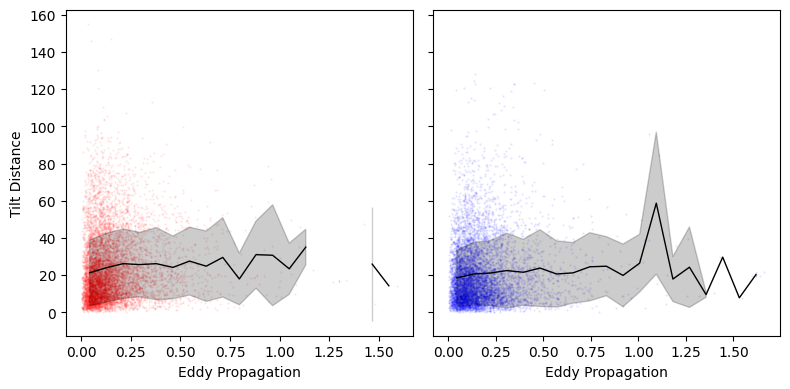

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()
    axs[p].scatter(df.EddyProp, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.EddyProp.min(), df.EddyProp.max(), 20)
    groups = df.groupby(pd.cut(df.EddyProp, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Eddy Propagation')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()

/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/1857787725.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df.w, bins, include_lowest=True))


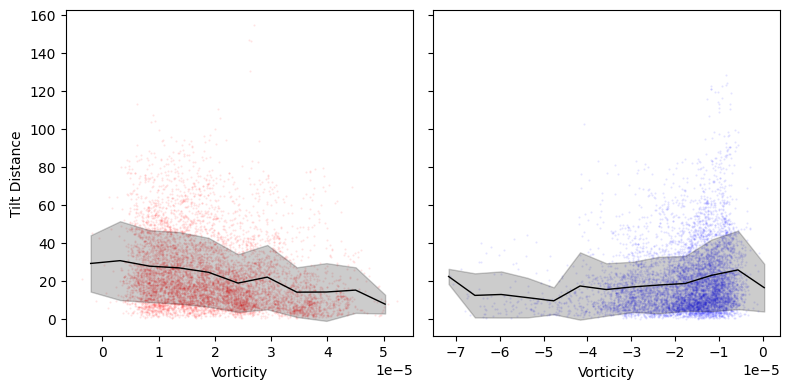

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()
    color = 'r' if cyc == 'AE' else 'b'
    axs[p].scatter(df.w, df.TiltDis, marker='.', color=color, s=1, alpha=.1)

    bins = np.linspace(df.w.min(), df.w.max(), 20)
    groups = df.groupby(pd.cut(df.w, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Vorticity')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/2231062755.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df.h/1000, bins, include_lowest=True))


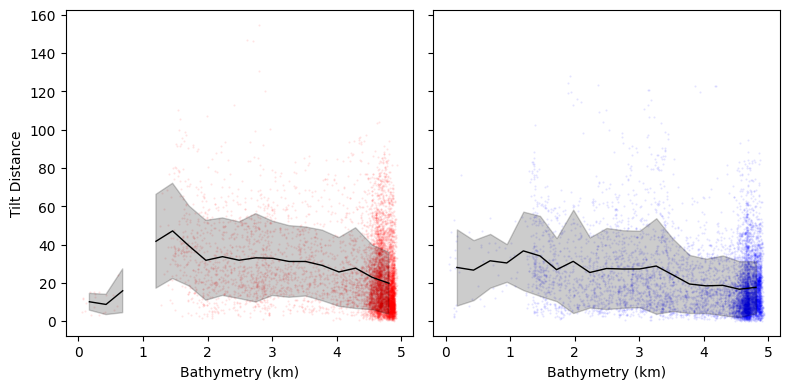

In [85]:
df_eddies_5yr['h'] = h[df_eddies_5yr.ic, df_eddies_5yr.jc]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()
    axs[p].scatter(df.h/1000, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace((df.h/1000).min(), (df.h/1000).max(), 20)
    groups = df.groupby(pd.cut(df.h/1000, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Bathymetry (km)')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()


/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/857131979.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df.s, bins, include_lowest=True))


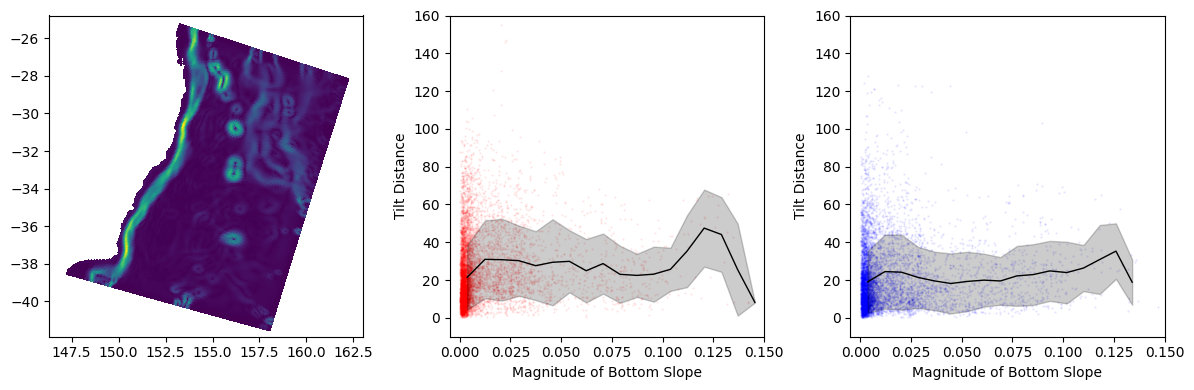

In [86]:
def slope_mag(h, X, Y, mask=None):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)

    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J

    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S

s = slope_mag(h/1000, X_grid, Y_grid, mask=mask_rho)

df_eddies_5yr['s'] = s[df_eddies_5yr.ic, df_eddies_5yr.jc]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].pcolor(lon_rho, lat_rho, s)
axs[0].axis('equal')

for p, cyc in enumerate(['AE', 'CE']):
    p += 1
    df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()
    axs[p].scatter(df.s, df.TiltDis, marker='.', color='r' if p == 1 else 'b', s=1, alpha=.1)

    bins = np.linspace(df.s.min(), df.s.max(), 20)
    groups = df.groupby(pd.cut(df.s, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Magnitude of Bottom Slope')
    axs[p].set_ylabel('Tilt Distance')
    axs[p].set_ylim(-10, 160)
    axs[p].set_xlim(-.005, .150)

plt.tight_layout()



/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/983017277.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = 1 / np.sqrt(eigvals.min())
/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/983017277.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df.Eccent, bins, include_lowest=True))


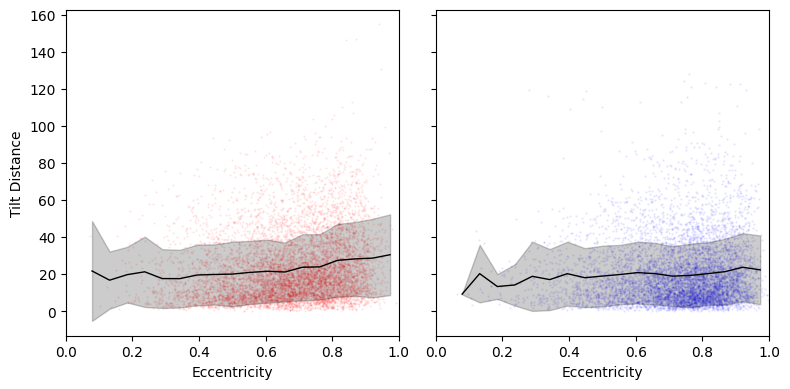

In [87]:
def eccentricity_from_Q(Q, definition="eccentricity"):
    eigvals = np.linalg.eigvalsh(Q)
    a = 1 / np.sqrt(eigvals.min())
    b = 1 / np.sqrt(eigvals.max())
    
    if definition == "axis_ratio":
        return a / b
    elif definition == "ellipticity":
        return 1 - b / a
    elif definition == "eccentricity":
        return np.sqrt(1 - (b/a)**2)
    else:
        raise ValueError("Unknown definition")

df_eddies_5yr['Eccent'] = df_eddies_5yr.apply(
    lambda row: eccentricity_from_Q(
        np.array([[np.abs(row.Q11), row.Q12],
                  [row.Q12, np.abs(row.Q22)]])
    ),
    axis=1
)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for p, cyc in enumerate(['AE', 'CE']):
    df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()
    axs[p].scatter(df.Eccent, df.TiltDis, marker='.', color='r' if p == 0 else 'b', s=1, alpha=.1)

    bins = np.linspace(0, 1, 20)
    groups = df.groupby(pd.cut(df.Eccent, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlim(0, 1)
    axs[p].set_xlabel('Eccentricity')
    if p == 0:
        axs[p].set_ylabel('Tilt Distance')

plt.tight_layout()




AE: Increasing 517.9 m per year
CE: Increasing 601.8 m per year


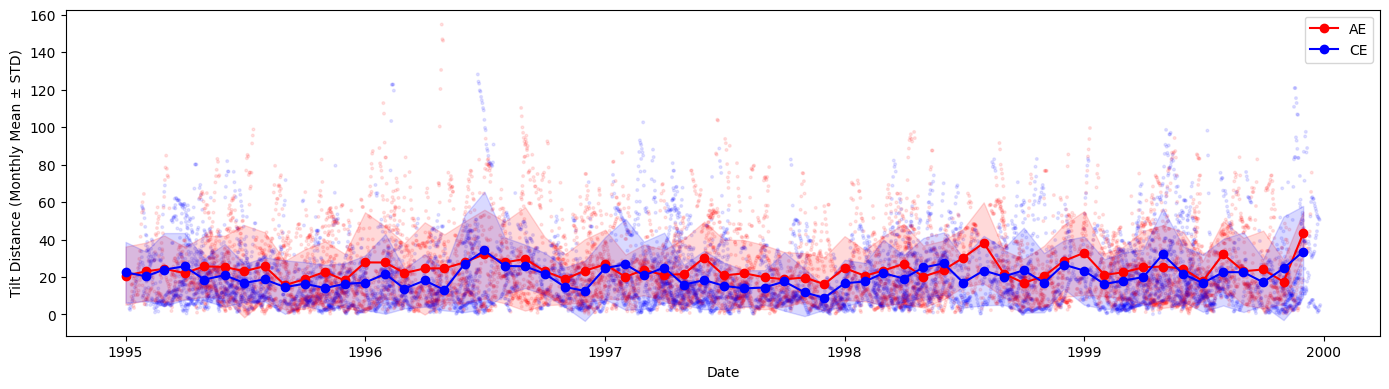

In [22]:
df_eddies_5yr['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies_5yr.Day, unit='D')

plt.figure(figsize=(14, 4))
clrs = np.where(df_eddies_5yr.Cyc == 'CE', 'b', 'r')
plt.scatter(df_eddies_5yr.Date, df_eddies_5yr.TiltDis, c=clrs, marker='.', s=15, alpha=0.1)

trend_results = {}
for cyc, colour in [('AE', 'red'), ('CE', 'b')]:
    df_masked = df_eddies_5yr[df_eddies_5yr.Cyc == cyc]
    grouped = df_masked.groupby(df_masked['Date'].dt.to_period('M'))['TiltDis']
    monthly_mean = grouped.mean()
    monthly_std = grouped.std()
    monthly_mean.index = monthly_mean.index.to_timestamp()
    monthly_std.index = monthly_std.index.to_timestamp()

    plt.plot(monthly_mean.index, monthly_mean, marker='o', color=colour, label=cyc)
    plt.fill_between(monthly_mean.index,
                     monthly_mean - monthly_std,
                     monthly_mean + monthly_std,
                     color=colour, alpha=0.15)

    coeffs = np.polyfit(np.arange(len(monthly_mean)), monthly_mean, 1)
    trend_results[cyc] = coeffs[0]

plt.xlabel('Date')
plt.ylabel('Tilt Distance (Monthly Mean ± STD)')
plt.legend()
plt.tight_layout()

print(f"AE: {'Increasing' if trend_results['AE'] > 0 else 'Decreasing'} {trend_results['AE']*12*1000:.1f} m per year")
print(f"CE: {'Increasing' if trend_results['CE'] > 0 else 'Decreasing'} {trend_results['CE']*12*1000:.1f} m per year")



AE: Increasing 517.9 m per year
CE: Increasing 601.8 m per year


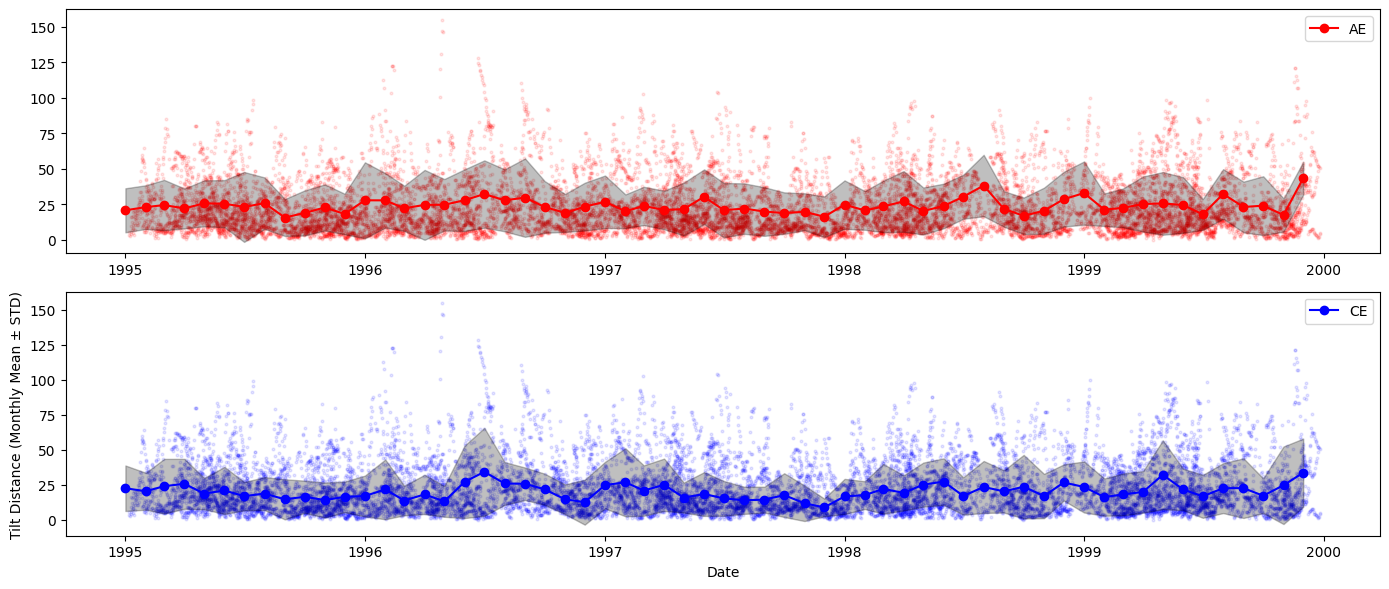

In [23]:
df_eddies_5yr['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies_5yr.Day, unit='D')

fig, axs = plt.subplots(2, 1, figsize=(14, 6))
clrs = np.where(df_eddies_5yr.Cyc == 'CE', 'b', 'r')

trend_results = {}
for p, (cyc, colour) in enumerate([('AE', 'red'), ('CE', 'b')]):
    df_masked = df_eddies_5yr[df_eddies_5yr.Cyc == cyc]
    axs[p].scatter(df_eddies_5yr.Date, df_eddies_5yr.TiltDis, c=colour, marker='.', s=15, alpha=0.1)
    grouped = df_masked.groupby(df_masked['Date'].dt.to_period('M'))['TiltDis']
    monthly_mean = grouped.mean()
    monthly_std = grouped.std()
    monthly_mean.index = monthly_mean.index.to_timestamp()
    monthly_std.index = monthly_std.index.to_timestamp()

    axs[p].plot(monthly_mean.index, monthly_mean, marker='o', color=colour, label=cyc)
    axs[p].fill_between(monthly_mean.index,
                     monthly_mean - monthly_std,
                     monthly_mean + monthly_std,
                     color='k', alpha=0.25)

    coeffs = np.polyfit(np.arange(len(monthly_mean)), monthly_mean, 1)
    trend_results[cyc] = coeffs[0]
    axs[p].legend()

plt.xlabel('Date')
plt.ylabel('Tilt Distance (Monthly Mean ± STD)')
plt.tight_layout()

print(f"AE: {'Increasing' if trend_results['AE'] > 0 else 'Decreasing'} {trend_results['AE']*12*1000:.1f} m per year")
print(f"CE: {'Increasing' if trend_results['CE'] > 0 else 'Decreasing'} {trend_results['CE']*12*1000:.1f} m per year")



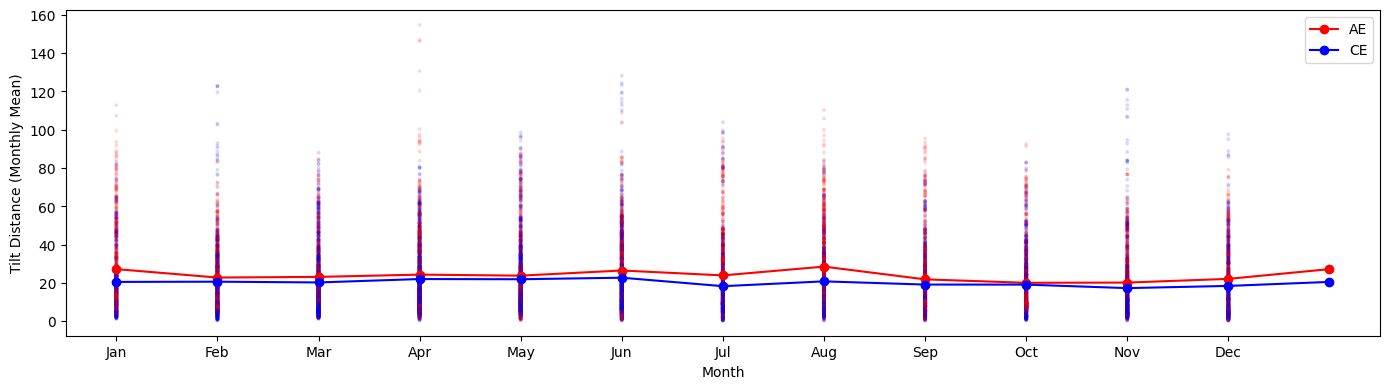

In [24]:
df_eddies_5yr['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df_eddies_5yr.Day, unit='D')

plt.figure(figsize=(14, 4))
m = df_eddies_5yr['Date'].dt.month
clrs = np.where(df_eddies_5yr.Cyc == 'CE', 'b', 'r')
plt.scatter(m, df_eddies_5yr.TiltDis, c=clrs, marker='.', s=15, alpha=0.1)

for cyc, colour in [('AE', 'red'), ('CE', 'b')]:
    d = df_eddies_5yr[df_eddies_5yr.Cyc == cyc]
    s = d.groupby(d['Date'].dt.month)['TiltDis'].mean().reindex(range(1, 13))
    x = np.r_[s.index, 13]
    y = np.r_[s.values, s.iloc[0]]
    plt.plot(x, y, marker='o', color=colour, label=cyc)

plt.xlim(.5, 13.5)
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month')
plt.ylabel('Tilt Distance (Monthly Mean)')
plt.legend()
plt.tight_layout()


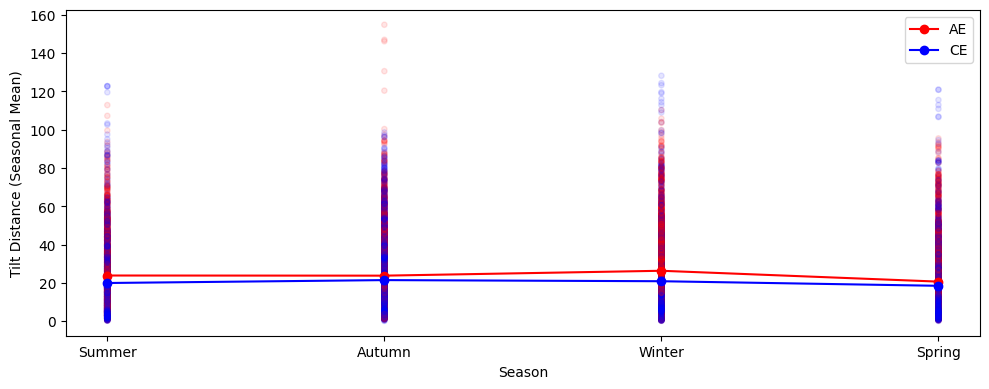

In [25]:
df = df_eddies_5yr.copy()
df['Date'] = pd.Timestamp('1990-01-01') + pd.to_timedelta(df.Day, unit='D')
season_map = {12:'Summer',1:'Summer',2:'Summer',3:'Autumn',4:'Autumn',5:'Autumn',6:'Winter',7:'Winter',8:'Winter',9:'Spring',10:'Spring',11:'Spring'}
order = ['Summer','Autumn','Winter','Spring']
df['Season'] = pd.Categorical(df['Date'].dt.month.map(season_map), categories=order, ordered=True)

plt.figure(figsize=(10,4))
x_scatter = df['Season'].cat.codes + 1
clrs = np.where(df.Cyc=='CE','b','r')
plt.scatter(x_scatter, df.TiltDis, c=clrs, s=15, alpha=0.1)

for cyc, colour in [('AE','red'), ('CE','b')]:
    s = df[df.Cyc == cyc].groupby('Season', observed=False)['TiltDis'].mean().reindex(order)
    x = np.arange(1, 5)
    plt.plot(x, s.values, marker='o', color=colour, label=cyc)

plt.xticks(np.arange(1,5), order)
plt.xlabel('Season')
plt.ylabel('Tilt Distance (Seasonal Mean)')
plt.legend()
plt.tight_layout()




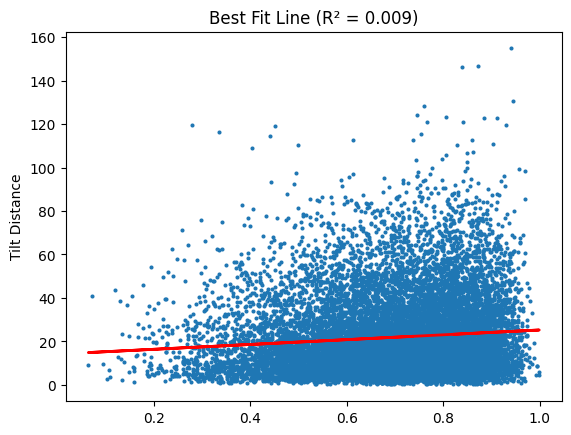

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Example data (replace with actual df data)
eddy_prop = np.array(df_eddies_5yr.Eccent)
df_TiltDis = df_eddies_5yr.TiltDis

mask = ~np.isnan(eddy_prop) & ~np.isnan(df_TiltDis)
X = eddy_prop[mask].reshape(-1, 1)
y = df_TiltDis[mask]

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

plt.scatter(X, y, marker='.', s=15)
plt.plot(X, y_pred, color='red', linewidth=2)
# plt.xlabel('Eddy Propagation (m/s)')
plt.ylabel('Tilt Distance')
plt.title(f'Best Fit Line (R² = {r2:.3f})')
plt.show()


#### Topographic Beta / Sloping bottom 

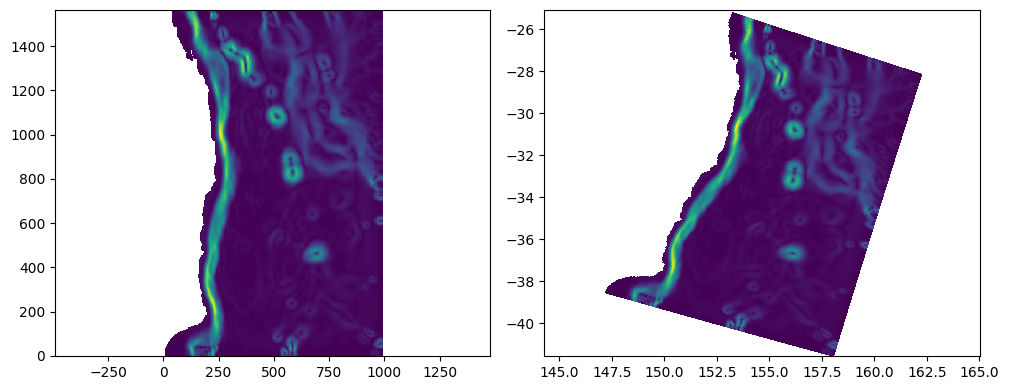

In [34]:
def slope_mag(h, X, Y, mask=None):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)

    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J

    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S

s = slope_mag(h/1000, X_grid, Y_grid, mask=mask_rho)
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].pcolor(X_grid, Y_grid, s)
axs[0].axis('equal')
axs[1].pcolor(lon_rho, lat_rho, s)
axs[1].axis('equal')
plt.tight_layout()


In [53]:
# s_means = []
# for _, snap in df_eddies_5yr.iterrows():
#     eddy, day = snap.Eddy, snap.Day
#     df = dic_5yr[f'Eddy{eddy}'][f'Day{day}']
#     mask = np.isnan(X_grid)
#     mask |= np.any([np.hypot(X_grid - d.x, Y_grid - d.y) <= d.Rc for _, d in df.iterrows()], axis=0)
#     s_means.append(np.nanmean(s[mask]))
# df_eddies_5yr['s_mean'] = s_means

/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/1064233851.py:7: RuntimeWarning: Mean of empty slice
  s_means.append(np.nanmean(s[mask]))


/scratch/pbs.6786520.kman.restech.unsw.edu.au/ipykernel_3139377/1964606115.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(pd.cut(df.s_mean, bins, include_lowest=True))


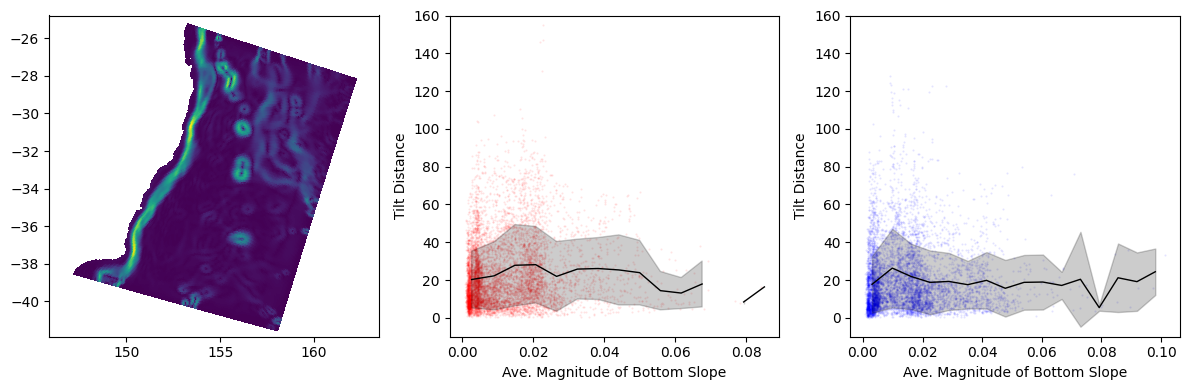

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].pcolor(lon_rho, lat_rho, s)
axs[0].axis('equal')

for p, cyc in enumerate(['AE', 'CE']):
    p += 1
    df = df_eddies_5yr[df_eddies_5yr.Cyc == cyc].copy()
    color = 'r' if cyc == 'AE' else 'b'
    axs[p].scatter(df.s_mean, df.TiltDis, marker='.', s=1, color=color, alpha=.1)

    bins = np.linspace(df.s_mean.min(), df.s_mean.max(), 20)
    groups = df.groupby(pd.cut(df.s_mean, bins, include_lowest=True))
    mean = groups['TiltDis'].mean()
    std = groups['TiltDis'].std()
    bin_centers = [interval.mid for interval in mean.index.categories]

    axs[p].plot(bin_centers, mean, color='k', lw=1)
    axs[p].fill_between(bin_centers, mean - std, mean + std, color='k', alpha=.2)

    axs[p].set_xlabel('Ave. Magnitude of Bottom Slope')
    axs[p].set_ylabel('Tilt Distance')
    axs[p].set_ylim(-10, 160)

plt.tight_layout()

